# iPython Profiler

IPython bietet Zugriff auf eine breite Palette von Funktionen um die Zeiten zu messen und Profile zu erstellen. Hier werden die folgenden magischen IPython-Befehle erläutert:

| Befehl         | Beschreibung                                                                      |
| -------------- | --------------------------------------------------------------------------------- |
| `%time`        | Zeit für die Ausführung einer einzelnen Anweisung                                 |
| `%timeit`      | Durchschnittliche Zeit für die wiederholte Ausführung einer einzelnen Anweisung   |
| `%prun`        | Code mit dem Profiler ausführen                                                   |
| `%lprun`       | Code mit dem zeilenweisen Profiler ausführen                                      |
| `%memit`       | Messen der Speichernutzung einer einzelnen Anweisung                              |
| `%mprun`       | Führt den Code mit dem zeilenweisen Memory-Profiler aus                           |

Die letzten vier Befehle sind nicht in IPython selbst, sondern in den Modulen [line_profiler](https://github.com/pyutils/line_profiler) und [memory_profiler](https://github.com/pythonprofilers/memory_profiler) enthalten.

## `%timeit` und `%time`

Wir haben die `%timeit`Zeilen- und `%%timeit`-Zellmagie bereits in der Einführung der magischen Funktionen in IPython Magic Commands gesehen. Sie können für Zeitmessungen bei der wiederholten Ausführung von Code-Schnipseln verwendet werden:

In [1]:
%timeit sum(range(100))

1.42 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Beachtet, dass `%timeit` die Ausführung mehrfach in einer Schleife (`loops`) ausführt. Wenn mit `-n` nicht die Anzahl der Schleifen festgelegt wird, passt `%timeit` die Anzahl automatisch so an, dass ein ausreichende Messgenauigkeit erreicht wird:

In [2]:
%%timeit
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

503 ms ± 83.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Manchmal ist das Wiederholen einer Operation nicht die beste Option, z.B. wenn wir eine Liste haben, die wir sortieren möchten. Hier werden wir möglicherweise durch eine wiederholte Operation in die Irre geführt. Das Sortieren einer vorsortierten Liste ist viel schneller als das Sortieren einer unsortierten Liste, sodass die Wiederholung das Ergebnis verzerrt:

In [3]:
import random
L = [random.random() for i in range(100000)]
%timeit L.sort()

478 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Dann ist die `%time`-Funktion möglicherweise die bessere Wahl. Auch bei länger laufenden Befehlen, wenn kurze systembedingte Verzögerungen das Ergebnis wahrscheinlich kaum beeinflussen, dürfte `%time` die bessere Wahl sein:

In [4]:
import random
L = [random.random() for i in range(100000)]
%time L.sort()

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18.7 ms


Sortieren einer bereits sortierten Liste:

In [5]:
%time L.sort ()

CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 1.14 ms


Beachtet, wie viel schneller die vorsortierte Liste zu sortieren ist, aber beachtet auch, wie viel länger das Timing mit `%time` gegenüber `%timeit` dauert, sogar für die vorsortierte Liste. Dies ist auf die Tatsache zurückzuführen, dass `%timeit` einige clevere Dinge unternimmt, um zu verhindern, dass Systemaufrufe die Zeitmessung stören. So wird beispielsweise die *Garbage Collection* nicht mehr verwendeter Python-Objekte verhindert, die sich andernfalls auf die Zeitmessung auswirken könnten. Aus diesem Grund sind die `%timeit`-Ergebnisse normalerweise merklich schneller als die `%time`-Ergebnisse.

## Profilerstellung für Skripte: `%prun`

Ein Programm besteht aus vielen einzelnen Anweisungen, und manchmal ist es wichtiger, diese Anweisungen im Kontext zu messen, als sie selbst zu messen. Python enthält einen integrierten [Code-Profiler](https://docs.python.org/3/library/profile.html). IPython bietet jedoch eine wesentlich bequemere Möglichkeit, diesen Profiler in Form der Magic-Funktion zu verwenden: `%prun`.

Als Beispiel definieren wir eine einfache Funktion, die einige Berechnungen durchführt:

In [6]:
def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
    return total

In [7]:
%prun sum_of_lists(1000000)

Im Notebook sieht die Ausgabe ungefähr so aus:

```
14 function calls in 9.597 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    8.121    1.624    8.121    1.624 <ipython-input-15-f105717832a2>:4(<listcomp>)
        5    0.747    0.149    0.747    0.149 {built-in method builtins.sum}
        1    0.665    0.665    9.533    9.533 <ipython-input-15-f105717832a2>:1(sum_of_lists)
        1    0.065    0.065    9.597    9.597 <string>:1(<module>)
        1    0.000    0.000    9.597    9.597 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

Das Ergebnis ist eine Tabelle, die sortiert nach Gesamtzeit für jeden Funktionsaufruf die Ausführungsdauer angibt. In diesem Fall wird die meiste Zeit mit *List Comprehension* innerhalb von `sum_of_lists` verbraucht. Dies gibt uns Anhaltspunkte, an welcher Stelle wir die Effizienz des Algorithmus verbessern könnten.

## Zeilenweise Profilerstellung: `%lprun`

Die Profilerstellung von `%prun` ist nützlich, aber manchmal ist ein zeilenweiser Profilreport aufschlussreicher. Dies ist nicht in Python oder IPython integriert, aber mit [line_profiler](https://github.com/rkern/line_profiler) steht ein Paket zur Verfügung, das dies ermöglicht. Diese kann in eurem Kernel bereitgestellt werden mit

```
$ spack env activate python-374
$ spack install py-line-profiler ^python@3.7.4%gcc@9.1.0
```

Alternativ könnt ihr `line-profiler` auch mit anderen Paketmanagern installieren, z.B.

```
$ pipenv install line_profiler
```

Falls ihr Python 3.7.x verwendet und die Fehlermeldung bekommt `error: command 'clang' failed with exit status 1`, bleibt aktuell nur, `Cython` zusammen mit den Ressourcen aus dem Git-Repository zu installieren:

```
$ pipenv install Cython git+https://github.com/rkern/line_profiler.git#egg=line_profiler
```

Nun könnt ihr IPython mit der `line_profiler`-Erweiterung laden:

In [8]:
%load_ext line_profiler

Der `%lprun`-Befehl führt eine zeilenweise Profilerstellung für jede Funktion durch. In diesem Fall muss explizit angegeben werden, welche Funktionen für die Profilerstellung interessant sind:

In [9]:
%lprun -f sum_of_lists sum_of_lists(5000)

Das Ergebnis sieht ungefähr so aus:

```
Timer unit: 1e-06 s

Total time: 0.015145 s
File: <ipython-input-6-f105717832a2>
Function: sum_of_lists at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def sum_of_lists(N):
     2         1          1.0      1.0      0.0      total = 0
     3         6         11.0      1.8      0.1      for i in range(5):
     4         5      14804.0   2960.8     97.7          L = [j ^ (j >> i) for j in range(N)]
     5         5        329.0     65.8      2.2          total += sum(L)
     6         1          0.0      0.0      0.0      return total
```

Die Zeit wird in Mikrosekunden angegeben und wir können sehen, in welcher Zeile die Funktion die meiste Zeit verbringt. Eventuell können wir das Skript dann so ändern, dass die Effizienz der Funktion gesteigert werden kann.

Weitere Informationen zu `%lprun` sowie die verfügbaren Optionen findet ihr in der IPython-Hilfefunktion `%lprun?`.

## Speicherprofil erstellen:  `%memit` und `%mprun`

Ein weiterer Aspekt der Profilerstellung ist die Speichermenge, die eine Operation verwendet. Dies kann mit einer anderen IPython-Erweiterung ausgewertet werden, dem `memory_profiler`. Diese kann in eurem Kernel bereitgestellt werden mit

```
$ spack env activate python-374
$ spack install py-memory-profiler ^python@3.7.4%gcc@9.1.0
```

Alternativ könnt ihr `memory-profiler` auch mit anderen Paketmanagern installieren, z.B.

```
$ pipenv install memory_profiler
```

In [10]:
%load_ext memory_profiler

In [11]:
%memit sum_of_lists(1000000)

peak memory: 136.37 MiB, increment: 69.42 MiB


Wir sehen, dass diese Funktion ungefähr 100 MB Speicher belegt.

Für eine zeilenweise Beschreibung der Speichernutzung können wir die `%mprun`-Magie verwenden. Leider funktioniert diese Magie nur für Funktionen, die in separaten Modulen definiert sind, und nicht für das Notebook selbst. Daher erstellen wir zunächst mit der `%%file`-Magie ein einfaches Modul mit dem Namen `mprun_demo.py`, das unsere `sum_of_lists`-Funktion enthält.

In [12]:
%%file mprun_demo.py
from memory_profiler import profile
  
@profile
def my_func():
    a = [1] * (10 ** 6)
    b = [2] * (2 * 10 ** 7)
    del b
    return a

Writing mprun_demo.py


In [13]:
from mprun_demo import my_func
%mprun -f my_func my_func()

Filename: /srv/jupyter/jupyter-tutorial-de/docs/performance/mprun_demo.py

Line #    Mem usage    Increment   Line Contents
     3     67.3 MiB     67.3 MiB   @profile
     4                             def my_func():
     5     74.8 MiB      7.5 MiB       a = [1] * (10 ** 6)
     6    227.4 MiB    152.6 MiB       b = [2] * (2 * 10 ** 7)
     7     74.9 MiB      0.0 MiB       del b
     8     74.9 MiB      0.0 MiB       return a





Hier zeigt die `Increment`-Spalte, wie stark sich jede Zeile auf den gesamten Speicherverbrauch auswirkt: Beachtet, dass wir beim Berechnen von `b` etwa 160 MB Speicher zusätzlich benötigen; dieser wird aber durch das Löschen von `b` nicht wieder freigegeben.

Weitere Informationen zu `%memit` und `%mprun` sowie deren Optionen findet ihr in der IPython-Hilfe mit `%memit?`.

## pyheatmagic

[pyheatmagic](https://github.com/csurfer/pyheatmagic) ist eine Erweiterung, die den IPython-Magic-Befehl `%%heat` zum Anzeigen von Python-Code als Heatmap mit [Py-Heat](https://github.com/csurfer/pyheat) erlaubt.

Sie lässt sich einfach im Kernel installieren mit

```
$ pipenv install py-heat-magic
Installing py-heat-magic…
…```

### Laden der Extension in IPython

In [14]:
%load_ext heat

### Anzeigen der Heatmap

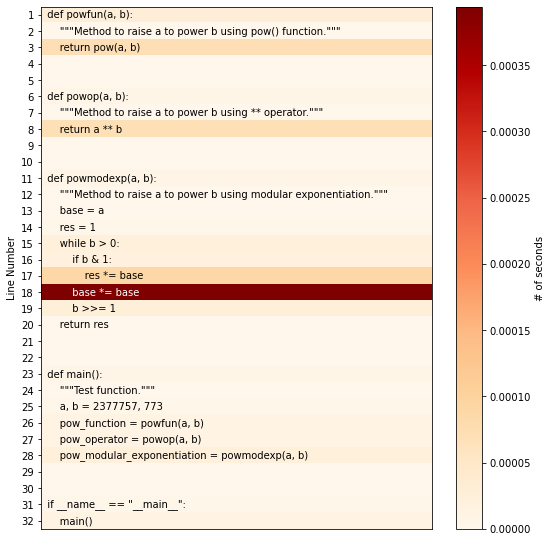

In [15]:
%%heat
def powfun(a, b):
    """Method to raise a to power b using pow() function."""
    return pow(a, b)


def powop(a, b):
    """Method to raise a to power b using ** operator."""
    return a ** b


def powmodexp(a, b):
    """Method to raise a to power b using modular exponentiation."""
    base = a
    res = 1
    while b > 0:
        if b & 1:
            res *= base
        base *= base
        b >>= 1
    return res


def main():
    """Test function."""
    a, b = 2377757, 773
    pow_function = powfun(a, b)
    pow_operator = powop(a, b)
    pow_modular_exponentiation = powmodexp(a, b)


if __name__ == "__main__":
    main()


Alternativ kann die Heatmap auch als Datei gespeichert werden, z.B. mit
```
%%heat -o pow-heatmap.png
```

## Siehe auch:

* [Penn Machine Learning Benchmarks](https://github.com/EpistasisLab/pmlb)